# Bolt challenge

Importing dependencies

In [87]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore,chi2_contingency


Reading the datasets

In [2]:
df_orders = pd.read_csv('orders.csv')
df_order_stages = pd.read_csv('order_stages.csv')

Checking the data of orders dataset.

In [3]:
df_orders.head()

,task_id,order_id,customer_id,restaurant_id,city,restaurant_address_lng,restaurant_address_lat,delivery_address_lng,delivery_address_lat,order_state,order_promised_delivery,restaurant_finished_preparation
0,1,1,15116,721,Bucharest,26.074823,44.415090,26.014888,44.428852,delivered,2021-10-15T03:31:11.000Z,2021-10-15T03:08:44.000Z
1,1,2,12572,1445,Bucharest,26.054794,44.454021,26.093656,44.434069,delivered,2021-10-15T03:46:07.000Z,2021-10-15T03:24:22.000Z
2,1,3,34814,891,Bucharest,26.049776,44.424410,26.020117,44.411906,delivered,2021-10-15T04:00:30.000Z,2021-10-15T03:45:39.000Z
3,1,4,17168,368,Bucharest,26.143047,44.430457,26.126890,44.417530,delivered,2021-10-15T04:15:53.000Z,2021-10-15T04:08:40.000Z
4,1,5,35129,721,Bucharest,26.074823,44.415090,26.030227,44.433221,delivered,2021-10-15T04:44:42.000Z,2021-10-15T04:28:17.000Z


In [4]:
df_orders['city'].unique()

array(['Bucharest'], dtype=object)

In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65584 entries, 0 to 65583
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   task_id                          65584 non-null  int64  
 1   order_id                         65584 non-null  int64  
 2   customer_id                      65584 non-null  int64  
 3   restaurant_id                    65584 non-null  int64  
 4   city                             65584 non-null  object 
 5   restaurant_address_lng           65584 non-null  float64
 6   restaurant_address_lat           65584 non-null  float64
 7   delivery_address_lng             65584 non-null  float64
 8   delivery_address_lat             65584 non-null  float64
 9   order_state                      65584 non-null  object 
 10  order_promised_delivery          65584 non-null  object 
 11  restaurant_finished_preparation  65525 non-null  object 
dtypes: float64(4), int

There are none null values in the dataset. <br>
Note: The objects of timestamp are not in datetime and they have 'Z' at the end of the string indicating UTC time, but all the cities are in Europe/Bucharest.

In [6]:
df_orders.dtypes

task_id                              int64
order_id                             int64
customer_id                          int64
restaurant_id                        int64
city                                object
restaurant_address_lng             float64
restaurant_address_lat             float64
delivery_address_lng               float64
delivery_address_lat               float64
order_state                         object
order_promised_delivery             object
restaurant_finished_preparation     object
dtype: object

## **Working with orders dataset**

### Feature engineering

Here I'll build some new features to help with the analysis and also clean up redundant features.

In [7]:
### Feature engineering

# 1. Creation of distance between restaurant and delivery address

def haversine(lat1, lon1, lat2, lon2):
    """
    Function to calculate the Haversine distance.
    The idea here is to cluster lat/lng features to have a better understanding of the data.
    Calculate the great-circle distance between two points on the Earth (specified in decimal degrees).
    Returns the distance in kilometers.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Creating a new feature to calculate the distance between restaurant and delivery address.
df_orders['restaurant_delivery_distance'] = haversine(df_orders['restaurant_address_lng'], df_orders['restaurant_address_lat'], df_orders['delivery_address_lng'], df_orders['delivery_address_lat'])

# Removing lat and lng columns
df_orders.drop(columns=['restaurant_address_lat', 'restaurant_address_lng', 'delivery_address_lat', 'delivery_address_lng'], inplace=True)

# 2. Converting order_promised_delivery_time to datetime
df_orders['order_promised_delivery'] = pd.to_datetime(df_orders['order_promised_delivery']).dt.tz_localize(None)

# 3. Converting order_created_at to datetime
df_orders['restaurant_finished_preparation'] = pd.to_datetime(df_orders['restaurant_finished_preparation']).dt.tz_localize(None)

# 4. Diference between order_promised_delivery and restaurant_finished_preparation
df_orders['dif_promised_preparation'] = df_orders['order_promised_delivery'] - df_orders['restaurant_finished_preparation']

# Converting the difference to minutes
df_orders['dif_promised_preparation'] = df_orders['dif_promised_preparation'].dt.total_seconds() / 60



Now, let's check the data.

In [8]:
df_orders.sort_values(by='dif_promised_preparation', ascending=False).head(10)

,task_id,order_id,customer_id,restaurant_id,city,order_state,order_promised_delivery,restaurant_finished_preparation,restaurant_delivery_distance,dif_promised_preparation
49030,1,49031,34038,1484,Bucharest,delivered,2021-11-10 16:17:59,2021-11-10 14:24:39,3.068341,113.333333
25025,1,25026,37406,195,Bucharest,delivered,2021-10-28 15:22:43,2021-10-28 13:47:16,2.441675,95.450000
18876,1,18877,23448,178,Bucharest,delivered,2021-10-25 13:47:23,2021-10-25 12:19:24,0.665101,87.983333
56289,1,56290,37406,195,Bucharest,delivered,2021-11-14 16:21:28,2021-11-14 14:55:08,2.441675,86.333333
8846,1,8847,45176,1484,Bucharest,delivered,2021-10-19 21:05:07,2021-10-19 19:43:03,6.666093,82.066667
4828,1,4829,25187,575,Bucharest,delivered,2021-10-17 19:57:48,2021-10-17 18:36:47,1.897460,81.016667
13004,1,13005,44050,178,Bucharest,delivered,2021-10-21 21:37:47,2021-10-21 20:18:24,0.153622,79.383333
7683,1,7684,12446,277,Bucharest,delivered,2021-10-19 12:40:38,2021-10-19 11:23:04,4.430022,77.566667
34233,1,34234,30729,1144,Bucharest,delivered,2021-11-02 14:47:58,2021-11-02 13:33:30,2.642104,74.466667
15244,1,15245,29306,575,Bucharest,delivered,2021-10-22 23:10:12,2021-10-22 21:58:09,0.898165,72.050000


I want to transform the order_state column to binary.

In [9]:
df_orders['order_state'] = df_orders['order_state'].replace({'delivered': 1, 'failed': 0})


/var/folders/wr/tth9g68x4pq8xw10b_dqg0qm0000gn/T/ipykernel_31831/218076531.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_orders['order_state'] = df_orders['order_state'].replace({'delivered': 1, 'failed': 0})


Let's see the distribution of the order_state column.

In [10]:
df_orders[['order_id','order_state']].groupby('order_state').count()


,order_id
order_state,
0,111
1,65473


In [11]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65584 entries, 0 to 65583
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   task_id                          65584 non-null  int64         
 1   order_id                         65584 non-null  int64         
 2   customer_id                      65584 non-null  int64         
 3   restaurant_id                    65584 non-null  int64         
 4   city                             65584 non-null  object        
 5   order_state                      65584 non-null  int64         
 6   order_promised_delivery          65584 non-null  datetime64[ns]
 7   restaurant_finished_preparation  65525 non-null  datetime64[ns]
 8   restaurant_delivery_distance     65584 non-null  float64       
 9   dif_promised_preparation         65525 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(5), object(1)
memo

The features are not balanced. This might be a problem for a future model if needed. <br>
At the same time, it shows that the operation may be very efficient. <br>
Now, let's visualize the data.


### Data visualization of orders dataset

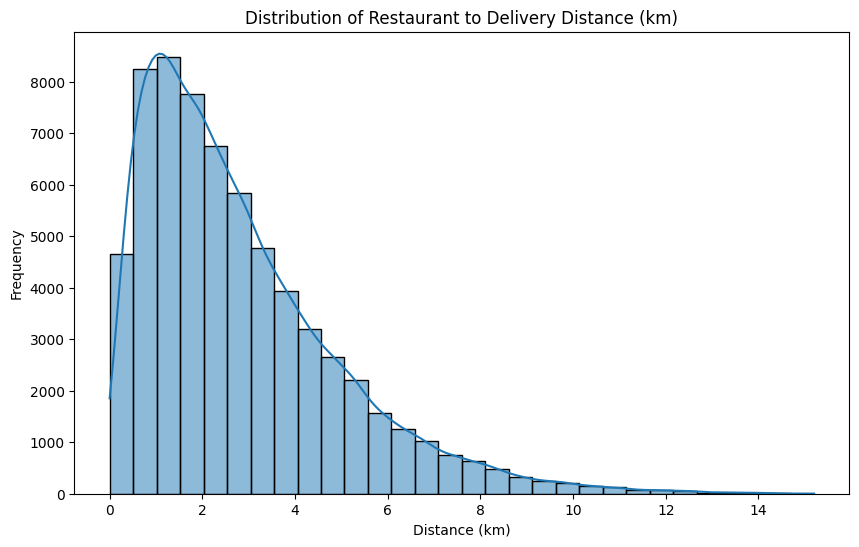

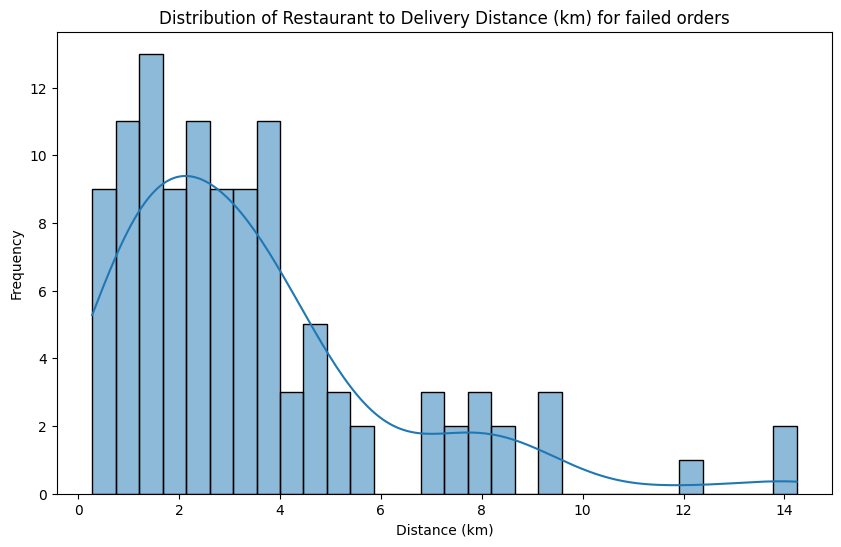

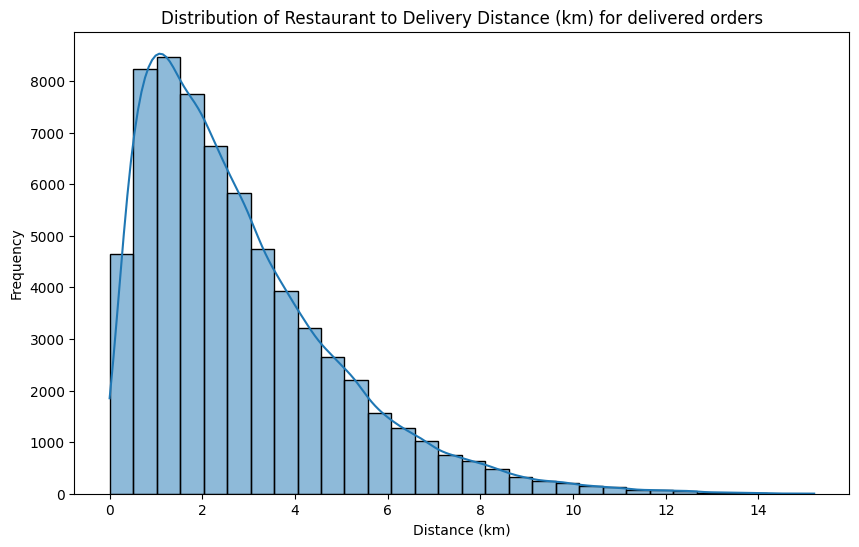

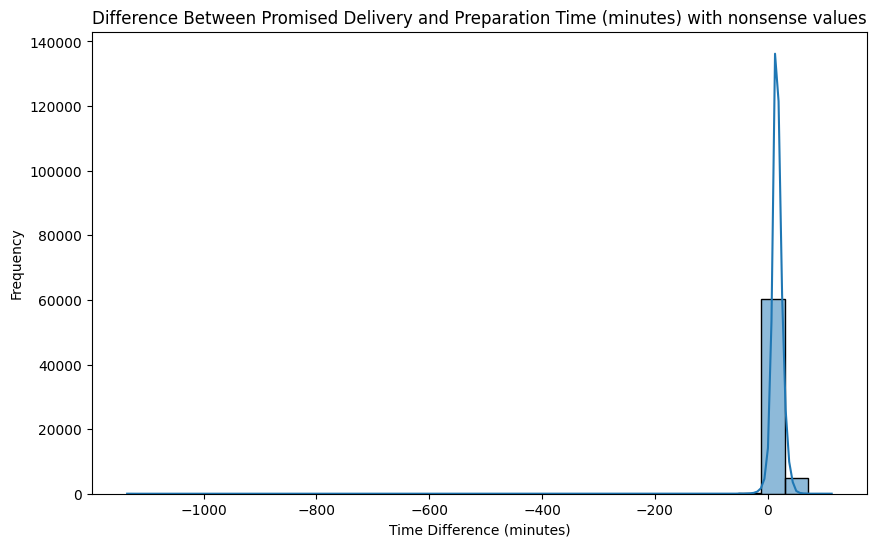

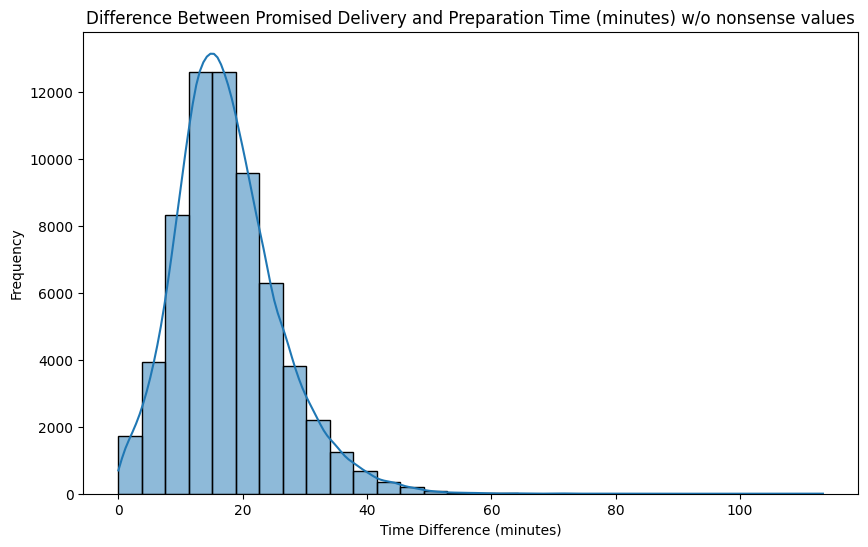

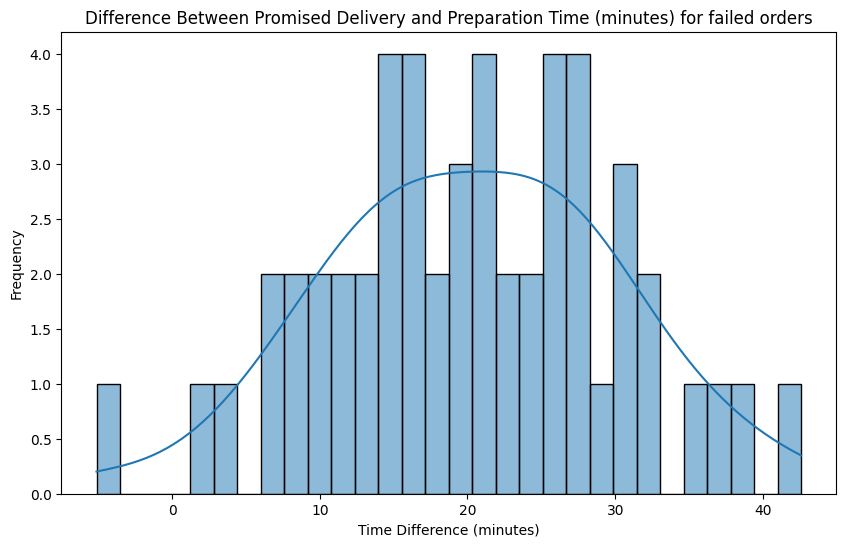

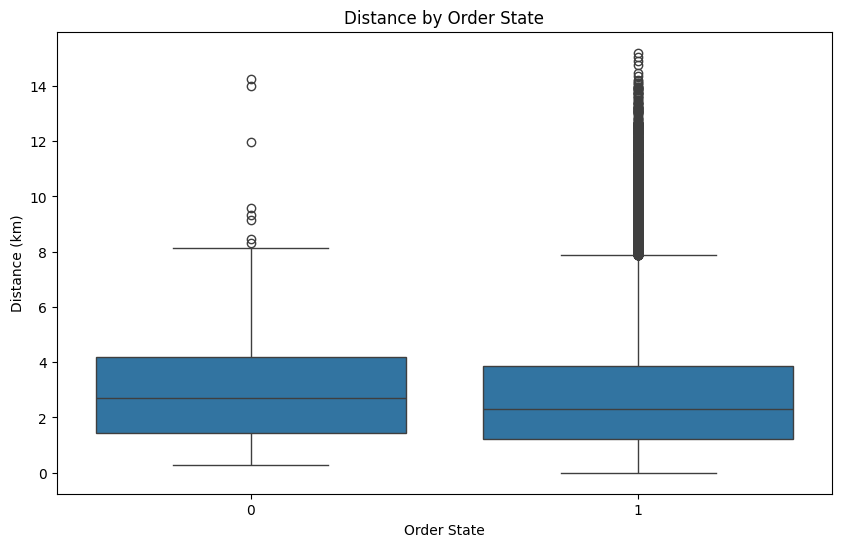

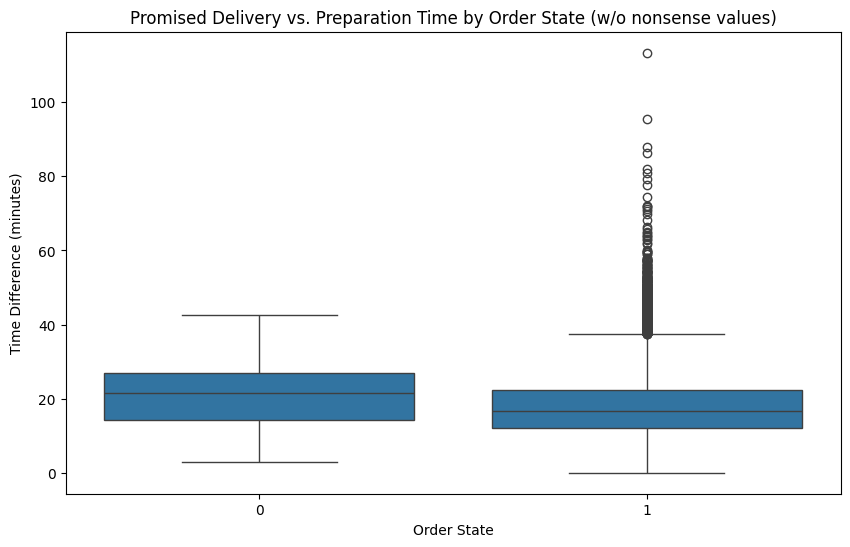

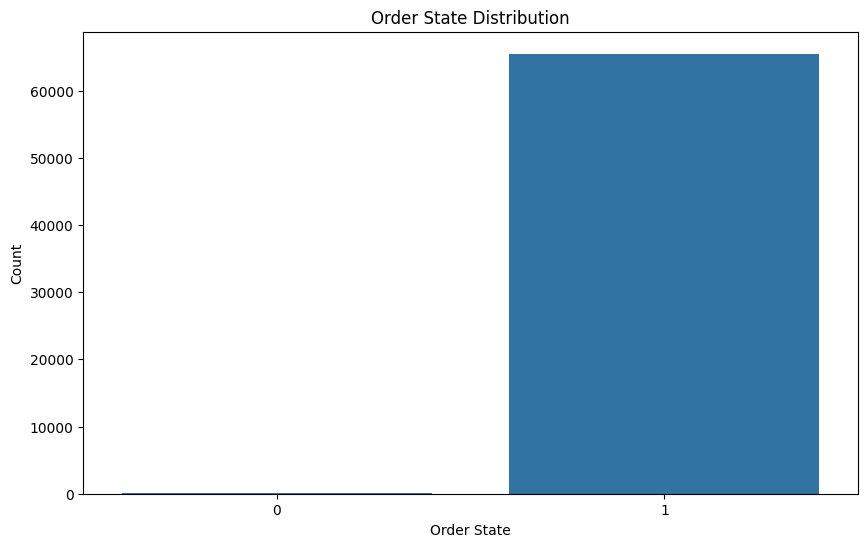

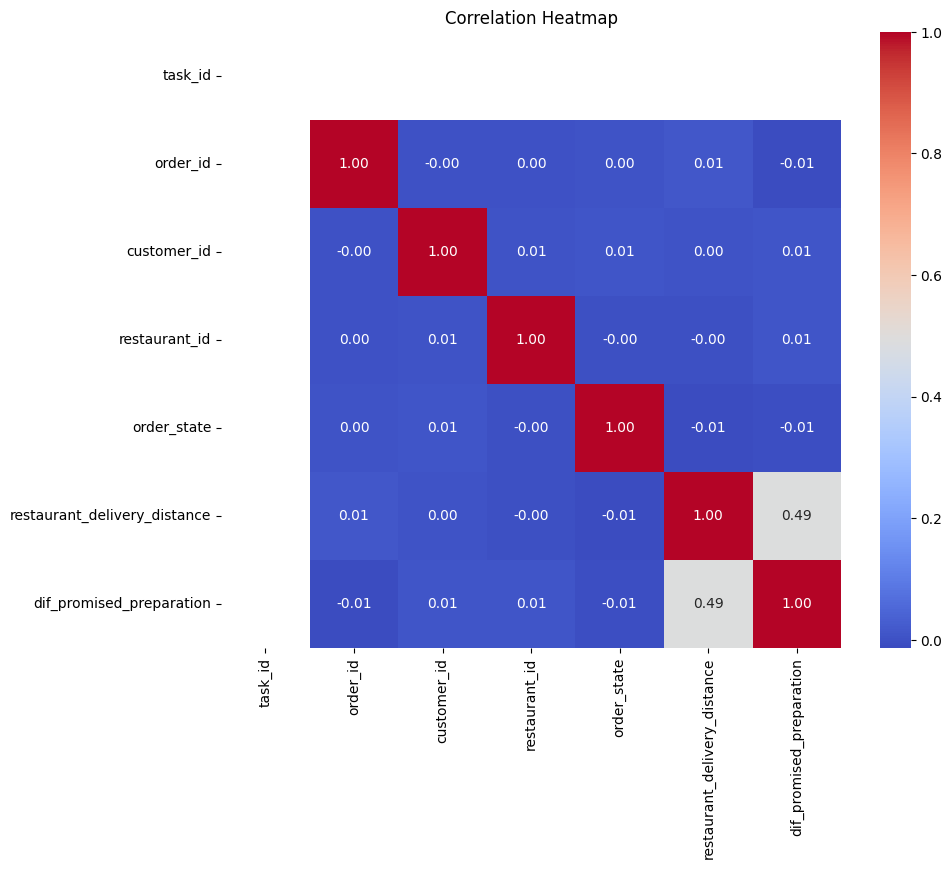

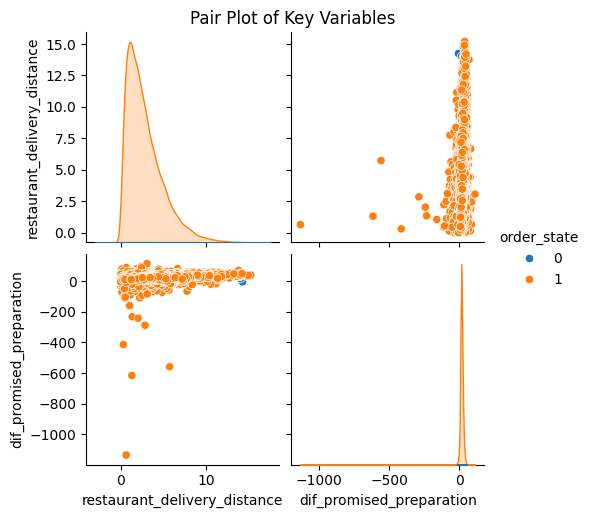

In [12]:
# Data visualization using seaborn

# 1a. Distribution of restaurant_delivery_distance
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['restaurant_delivery_distance'], kde=True, bins=30)
plt.title('Distribution of Restaurant to Delivery Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

# 1b. Distribution of restaurant_delivery_distance for failed orders
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['restaurant_delivery_distance'].loc[df_orders['order_state']==0], kde=True, bins=30)
plt.title('Distribution of Restaurant to Delivery Distance (km) for failed orders')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

# 1b. Distribution of restaurant_delivery_distance for delivered orders
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['restaurant_delivery_distance'].loc[df_orders['order_state']==1], kde=True, bins=30)
plt.title('Distribution of Restaurant to Delivery Distance (km) for delivered orders')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.show()

# 2a. Difference between promised delivery and preparation time 
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['dif_promised_preparation'], kde=True, bins=30)
plt.title('Difference Between Promised Delivery and Preparation Time (minutes) with nonsense values')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.show()

# 2b. Difference between promised delivery and preparation time (without nonsense values)
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['dif_promised_preparation'].loc[df_orders['dif_promised_preparation'] > 0], kde=True, bins=30)
plt.title('Difference Between Promised Delivery and Preparation Time (minutes) w/o nonsense values')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.show()

# 2b. Difference between promised delivery and preparation time for failed orders
plt.figure(figsize=(10, 6))
sns.histplot(df_orders['dif_promised_preparation'].loc[df_orders['order_state']==0], kde=True, bins=30)
plt.title('Difference Between Promised Delivery and Preparation Time (minutes) for failed orders')
plt.xlabel('Time Difference (minutes)')
plt.ylabel('Frequency')
plt.show()

# 3. Boxplot of distance by order state
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_orders, x='order_state', y='restaurant_delivery_distance')
plt.title('Distance by Order State')
plt.xlabel('Order State')
plt.ylabel('Distance (km)')
plt.show()

# 4. Boxplot of time difference by order state without nonsense values
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_orders.loc[df_orders['dif_promised_preparation'] > 0], x='order_state', y='dif_promised_preparation')
plt.title('Promised Delivery vs. Preparation Time by Order State (w/o nonsense values)')
plt.xlabel('Order State')
plt.ylabel('Time Difference (minutes)')
plt.show()

# 5. Countplot of order states
plt.figure(figsize=(10, 6))
sns.countplot(data=df_orders, x='order_state')
plt.title('Order State Distribution')
plt.xlabel('Order State')
plt.ylabel('Count')
plt.show()

# 6. Correlation matrix

numerical_columns = df_orders.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(10, 8))
sns.heatmap(df_orders[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# 7. Pair plot of key variables
sns.pairplot(df_orders, vars=['restaurant_delivery_distance', 'dif_promised_preparation'], hue='order_state')
plt.suptitle('Pair Plot of Key Variables', y=1.02)
plt.show()





Generally, orders that were delivered were more likely to have a shorter distance and a shorter time difference between promised delivery and preparation. <br>But, the amount of failed orders were not very significant in the dataset, and we cannot conclude that farther distance or longer time difference between promised delivery and preparation are the main reasons for failed orders.
<br>There are also some outliers in the dataset that should be investigated.

## **Working with order_stages dataset**

### General analysis

Let's check the data of order_stages dataset.

In [13]:
df_order_stages.head()

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
0,1,Bucharest,1,677,motorbike,order_proposed_to_courier,2021-10-15 03:04:02.000,26.082872,44.416126,NaN,NaN,649.953324,NaN,2021-10-15 03:27:30.000,1
1,2,Bucharest,1,677,motorbike,courier_accepts_order,2021-10-15 03:04:12.000,26.082872,44.416126,218.0,NaN,649.953324,NaN,2021-10-15 03:27:10.000,1
2,3,Bucharest,1,677,motorbike,courier_arrived_at_restaurant,2021-10-15 03:08:51.000,26.074600,44.414964,NaN,NaN,22.596096,NaN,2021-10-15 03:26:36.000,1
3,4,Bucharest,1,677,motorbike,courier_picked_up_order,2021-10-15 03:08:54.000,26.074581,44.414966,NaN,756.0,23.668382,4988.52796,2021-10-15 03:24:39.000,1
4,5,Bucharest,2,1970,motorbike,order_proposed_to_courier,2021-10-15 03:24:02.000,26.040890,44.479828,NaN,NaN,3076.131080,NaN,2021-10-15 03:46:36.000,1


In [14]:
df_order_stages['city'].unique()

array(['Bucharest'], dtype=object)

As we can see above, the dataset is structured in a way that we can see the stages of each order. If a column is not related with the current stage, it will be NaN. <br>
Note: The objects related to timestamp have no 'Z' at the end of the string indicating UTC time, but all the cities are in Europe/Bucharest, I'll assume that the data is in UTC time. <br>

In [15]:
df_order_stages['order_stage_start'] = pd.to_datetime(df_order_stages['order_stage_start'])
df_order_stages['updated_expected_delivery_time'] = pd.to_datetime(df_order_stages['updated_expected_delivery_time'])


In [16]:
df_order_stages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384937 entries, 0 to 384936
Data columns (total 15 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   log_id                                          384937 non-null  int64         
 1   city                                            384937 non-null  object        
 2   order_id                                        384937 non-null  int64         
 3   courier_id                                      384937 non-null  int64         
 4   vehicle_type                                    384937 non-null  object        
 5   order_stage                                     384937 non-null  object        
 6   order_stage_start                               384937 non-null  datetime64[ns]
 7   courier_location_lng_at_start                   384860 non-null  float64       
 8   courier_location_lat_at_start     

Dataset has also a lot of nonsense NaN values, so we need to clean it. But first, let's merge the datasets to have a better understanding of the data.

In [17]:
df_merged_order = pd.merge(df_orders[['order_id','order_state','order_promised_delivery','restaurant_finished_preparation','restaurant_delivery_distance','dif_promised_preparation']], df_order_stages, on='order_id', how='left')

# The column task_id does not add any value to the analysis, so we can drop it.
df_merged_order.drop(columns=['task_id'], inplace=True)
df_merged_order.head()

,order_id,order_state,order_promised_delivery,restaurant_finished_preparation,restaurant_delivery_distance,dif_promised_preparation,log_id,city,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time
0,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,1.0,Bucharest,677.0,motorbike,order_proposed_to_courier,2021-10-15 03:04:02,26.082872,44.416126,NaN,NaN,649.953324,NaN,2021-10-15 03:27:30
1,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,2.0,Bucharest,677.0,motorbike,courier_accepts_order,2021-10-15 03:04:12,26.082872,44.416126,218.0,NaN,649.953324,NaN,2021-10-15 03:27:10
2,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,3.0,Bucharest,677.0,motorbike,courier_arrived_at_restaurant,2021-10-15 03:08:51,26.074600,44.414964,NaN,NaN,22.596096,NaN,2021-10-15 03:26:36
3,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,4.0,Bucharest,677.0,motorbike,courier_picked_up_order,2021-10-15 03:08:54,26.074581,44.414966,NaN,756.0,23.668382,4988.527960,2021-10-15 03:24:39
4,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,11.0,Bucharest,677.0,motorbike,courier_arrived_at_customer,2021-10-15 03:38:01,26.015199,44.428529,NaN,NaN,NaN,43.611625,2021-10-15 03:38:01


Now we can deal with the NaN values.

In [18]:
# Remove rows where all columns are NaN
df_order_staged_cleaned = df_merged_order.dropna(how='all')

# Remove rows with a high proportion of NaN values (e.g., >60%)
threshold = 0.6
df_order_staged_cleaned = df_order_staged_cleaned.dropna(thresh=int(threshold * len(df_order_staged_cleaned.columns)))

Let's check some failed orders.

In [19]:
df_order_staged_cleaned.loc[df_order_staged_cleaned['order_state']==0].sort_values(by='order_stage_start', ascending=True).head()

,order_id,order_state,order_promised_delivery,restaurant_finished_preparation,restaurant_delivery_distance,dif_promised_preparation,log_id,city,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time
452,78,0,2021-10-15 11:27:40,NaT,8.322070,NaN,352.0,Bucharest,378.0,motorbike,order_proposed_to_courier,2021-10-15 10:48:42,26.089440,44.429962,NaN,NaN,625.495395,NaN,2021-10-15 11:21:13
2066,352,0,2021-10-15 12:49:40,2021-10-15 12:37:48,1.393264,11.866667,1652.0,Bucharest,2451.0,motorbike,order_proposed_to_courier,2021-10-15 12:26:46,26.126643,44.460737,NaN,NaN,490.075698,NaN,2021-10-15 12:45:27
2067,352,0,2021-10-15 12:49:40,2021-10-15 12:37:48,1.393264,11.866667,1658.0,Bucharest,2451.0,motorbike,courier_accepts_order,2021-10-15 12:26:57,26.126463,44.460447,240.0,NaN,456.308062,NaN,2021-10-15 13:02:15
3106,531,0,2021-10-15 13:55:05,2021-10-15 13:27:13,5.060110,27.866667,2791.0,Bucharest,2450.0,motorbike,order_proposed_to_courier,2021-10-15 13:13:36,26.098520,44.427649,NaN,NaN,671.687532,NaN,2021-10-15 13:46:29
3107,531,0,2021-10-15 13:55:05,2021-10-15 13:27:13,5.060110,27.866667,2793.0,Bucharest,2450.0,motorbike,courier_accepts_order,2021-10-15 13:13:48,26.098557,44.427682,351.0,NaN,669.205692,NaN,2021-10-15 13:46:11


In [20]:
df_order_stages.loc[(df_order_stages['courier_id']==2116) & (df_order_stages['order_id']==64963)].sort_values(by='order_stage_start', ascending=True)

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
381029,381030,Bucharest,64963,2116,motorbike,order_proposed_to_courier,2021-11-18 19:24:46,26.127015,44.419622,NaN,NaN,134.452046,NaN,2021-11-18 19:38:26,1
381032,381033,Bucharest,64963,2116,motorbike,courier_accepts_order,2021-11-18 19:24:56,26.127961,44.418749,59.0,NaN,92.464123,NaN,2021-11-18 19:38:06,1
381074,381075,Bucharest,64963,2116,motorbike,courier_arrived_at_restaurant,2021-11-18 19:28:11,26.128483,44.419215,NaN,NaN,26.078152,NaN,NaT,1


So, in order_stages, we cannot clearly understand exactly what happened to the failed order. Was it canceled? Did it had any trouble in delivery process? Let's try to investigate a little further.

### **Some ideas to investigate:** <br>
- **(Distance Analysis)**: Investigate whether distance_courier_to_restaurant_address is significantly higher for failed orders compared to successful ones. <br>
- **(Time related analysis)**: Analyze time differences between stages (e.g., from order_stage_start to updated_expected_delivery_time) to identify delays. <br>
- **(Time related analysis)**: Analyze if the expected delivery time is significantly different from order_promised_delivery_time for failed orders. <br>
- **(Courier efficiency)**: Investigate if vehicle type (vehicle_type) influences failure rates.


#### Time related analysis

Here I'll select only variables related to time in the beginning of the order_stages

In [21]:
df_time = df_order_staged_cleaned[['order_id','order_state','order_stage','courier_id','vehicle_type','order_promised_delivery','order_stage_start','restaurant_finished_preparation','updated_expected_delivery_time']].loc[df_order_staged_cleaned['order_stage']=='order_proposed_to_courier'].copy()
df_time['order_stage_start'] = pd.to_datetime(df_time['order_stage_start'])
df_time['updated_expected_delivery_time'] = pd.to_datetime(df_time['updated_expected_delivery_time'])


In [22]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64205 entries, 0 to 386310
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   order_id                         64205 non-null  int64         
 1   order_state                      64205 non-null  int64         
 2   order_stage                      64205 non-null  object        
 3   courier_id                       64205 non-null  float64       
 4   vehicle_type                     64205 non-null  object        
 5   order_promised_delivery          64205 non-null  datetime64[ns]
 6   order_stage_start                64205 non-null  datetime64[ns]
 7   restaurant_finished_preparation  64173 non-null  datetime64[ns]
 8   updated_expected_delivery_time   64184 non-null  datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(2), object(2)
memory usage: 4.9+ MB


Let's create some features with the comparation between times.

In [23]:
df_time.head()

,order_id,order_state,order_stage,courier_id,vehicle_type,order_promised_delivery,order_stage_start,restaurant_finished_preparation,updated_expected_delivery_time
0,1,1,order_proposed_to_courier,677.0,motorbike,2021-10-15 03:31:11,2021-10-15 03:04:02,2021-10-15 03:08:44,2021-10-15 03:27:30
6,2,1,order_proposed_to_courier,1970.0,motorbike,2021-10-15 03:46:07,2021-10-15 03:24:02,2021-10-15 03:24:22,2021-10-15 03:46:36
12,3,1,order_proposed_to_courier,843.0,motorbike,2021-10-15 04:00:30,2021-10-15 03:33:42,2021-10-15 03:45:39,2021-10-15 03:58:33
18,4,1,order_proposed_to_courier,2410.0,motorbike,2021-10-15 04:15:53,2021-10-15 03:55:32,2021-10-15 04:08:40,2021-10-15 04:13:18
24,5,1,order_proposed_to_courier,2588.0,car,2021-10-15 04:44:42,2021-10-15 04:14:42,2021-10-15 04:28:17,2021-10-15 04:41:12


In [24]:
#Difference between promised delivery and expected delivery time (in seconds)
df_time['dif_promised_expected'] = (
    df_time['updated_expected_delivery_time'] - df_time['order_promised_delivery']
).dt.total_seconds()

#Difference between finished preparation and expected delivery time (in seconds)
df_time['dif_finished_expected'] = (
    df_time['updated_expected_delivery_time'] - df_time['restaurant_finished_preparation']
).dt.total_seconds()

#Difference between finished preparation and promised delivery time (in seconds)
df_time['dif_finished_promised'] = (
    df_time['restaurant_finished_preparation'] - df_time['order_promised_delivery']
).dt.total_seconds()

#Difference between order stage start and expected delivery time (in seconds)
df_time['dif_start_expected'] = (
    df_time['order_stage_start'] - df_time['updated_expected_delivery_time']
).dt.total_seconds()

#Difference between order stage start and promised delivery time (in seconds)
df_time['dif_start_promised'] = (
    df_time['order_stage_start'] - df_time['order_promised_delivery']
).dt.total_seconds()

#Difference between order stage start and finished preparation time (in seconds)
df_time['dif_start_finished'] = (
    df_time['order_stage_start'] - df_time['restaurant_finished_preparation']
).dt.total_seconds()

df_time.head()


,order_id,order_state,order_stage,courier_id,vehicle_type,order_promised_delivery,order_stage_start,restaurant_finished_preparation,updated_expected_delivery_time,dif_promised_expected,dif_finished_expected,dif_finished_promised,dif_start_expected,dif_start_promised,dif_start_finished
0,1,1,order_proposed_to_courier,677.0,motorbike,2021-10-15 03:31:11,2021-10-15 03:04:02,2021-10-15 03:08:44,2021-10-15 03:27:30,-221.0,1126.0,-1347.0,-1408.0,-1629.0,-282.0
6,2,1,order_proposed_to_courier,1970.0,motorbike,2021-10-15 03:46:07,2021-10-15 03:24:02,2021-10-15 03:24:22,2021-10-15 03:46:36,29.0,1334.0,-1305.0,-1354.0,-1325.0,-20.0
12,3,1,order_proposed_to_courier,843.0,motorbike,2021-10-15 04:00:30,2021-10-15 03:33:42,2021-10-15 03:45:39,2021-10-15 03:58:33,-117.0,774.0,-891.0,-1491.0,-1608.0,-717.0
18,4,1,order_proposed_to_courier,2410.0,motorbike,2021-10-15 04:15:53,2021-10-15 03:55:32,2021-10-15 04:08:40,2021-10-15 04:13:18,-155.0,278.0,-433.0,-1066.0,-1221.0,-788.0
24,5,1,order_proposed_to_courier,2588.0,car,2021-10-15 04:44:42,2021-10-15 04:14:42,2021-10-15 04:28:17,2021-10-15 04:41:12,-210.0,775.0,-985.0,-1590.0,-1800.0,-815.0


I'll create a distplot grid to analyze the relationship of the new variables and order_state.

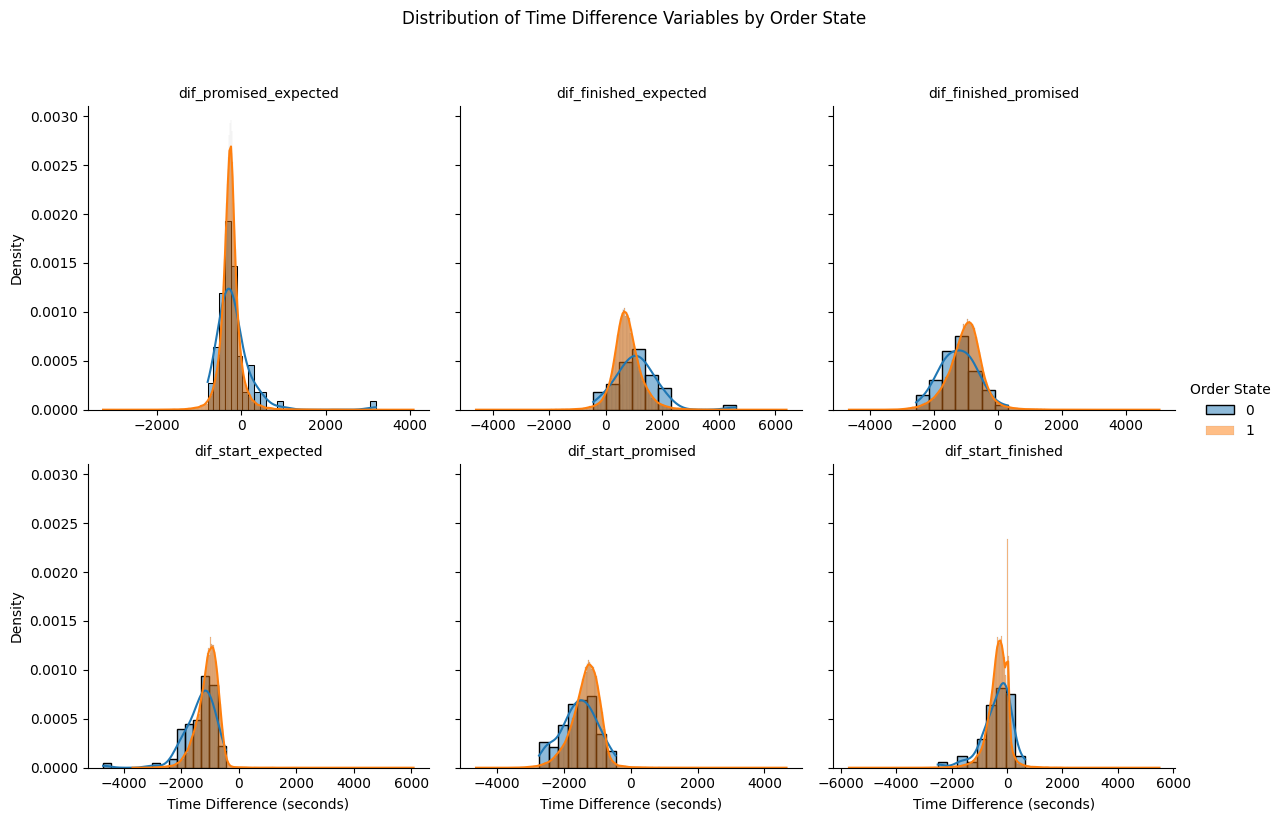

In [26]:
time_diff_vars = [
    'dif_promised_expected',
    'dif_finished_expected',
    'dif_finished_promised',
    'dif_start_expected',
    'dif_start_promised',
    'dif_start_finished'
]

# Create a FacetGrid for distribution plots
g = sns.FacetGrid(df_time.melt(id_vars=['order_state'], value_vars=time_diff_vars), 
                  col='variable', col_wrap=3, hue='order_state', sharex=False, height=4)

# Map the histplot to each facet
g.map(sns.histplot, 'value', kde=True, stat="density")

# Adjust titles and layout
g.set_titles('{col_name}')
g.set_axis_labels('Time Difference (seconds)', 'Density')
g.add_legend(title='Order State')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of Time Difference Variables by Order State', y=1.02)

# Show the plot
plt.show()

Now we can see more clearly that non-delivered orders have a slight difference in the distribution of the time difference variables. <br>
Here are some insights: <br>
<br>
Note: The closer to zero, smaller the difference. In this case, means more efficiency in delivery.
<br>
- The difference between promissed delivery and updated expected delivery time is not very significant, both are nearby zero. This indicates that we are promissing closer to updated expected delivery time.
- The difference between finished preparation and updated expected delivery is higher for non-delivered orders, this might indicate that the user may feel frustrated with the delivery time. We will check for significance later.
- The same behavior as above can be seen in finished preparation and promised delivery time.
- The difference between order started and updated delivery time is higher for non-delivery orders.
- Similar behavior as above for promised delivery and order started.
- The difference between finished preparation and order started is similar for both.

***Let's check for significance.***
Here are some rules:
1. First we'll check if the amount of data is enough to perform the test.
2. If it is, we'll check if the data is normally distributed based on Shapiro-Wilk or Kolmogorov-Smirnov.
3. If it is, we'll use t-test.
4. If it is not, we'll use Mann-Whitney U test.
5. If p-value is greater than 0.05, we'll consider the difference not significant.


In [43]:
from scipy.stats import shapiro, kstest, ttest_ind, mannwhitneyu

def evaluate_statistical_significance(df, target_column):
    """
    Evaluate statistical significance between 'delivered' and 'not delivered' for a single column.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing the data.
        target_column (str): The column to evaluate (e.g., 'dif_promised_expected').
        
    Returns:
        dict: A summary with normality results, test type, and p-value.
    """
    # Separate the data into two groups
    delivered = df[df['order_state'] == 1][target_column].dropna()
    not_delivered = df[df['order_state'] != 1][target_column].dropna()
    
    # Step 1: Handle cases with insufficient data
    if len(delivered) < 10 or len(not_delivered) < 10:
        return {
            'Column': target_column,
            'Delivered_Normality_p': None,
            'Not_Delivered_Normality_p': None,
            'Test_Type': 'Insufficient Data',
            'p_value': None
        }
    
    # Step 2: Check normality
    def check_normality(data):
        """Check normality using Shapiro-Wilk or Kolmogorov-Smirnov based on sample size."""
        if len(data) <= 5000:
            _, p_value = shapiro(data)
        else:
            _, p_value = kstest(data, 'norm')
        return p_value
    
    p_normality_delivered = check_normality(delivered)
    p_normality_not_delivered = check_normality(not_delivered)
    
    # Step 3: Determine test type
    if p_normality_delivered > 0.05 and p_normality_not_delivered > 0.05:
        # Both groups are normally distributed, use t-test
        stat, p_value = ttest_ind(delivered, not_delivered, equal_var=False)  # Welch's t-test
        test_type = 't-test'
    else:
        # At least one group is not normally distributed, use Mann-Whitney U Test
        stat, p_value = mannwhitneyu(delivered, not_delivered)
        test_type = 'Mann-Whitney U Test'
    
    # Step 4: Return results
    return {
        'Column': target_column,
        'Delivered_Normality_p': p_normality_delivered,
        'Not_Delivered_Normality_p': p_normality_not_delivered,
        'Test_Type': test_type,
        'p_value': p_value
    }



In [45]:
target_columns = [
    'dif_promised_expected', 
    'dif_finished_expected', 
    'dif_finished_promised', 
    'dif_start_expected', 
    'dif_start_promised', 
    'dif_start_finished'
]

results = [evaluate_statistical_significance(df_time, col) for col in target_columns]
results_df = pd.DataFrame(results)

pd.DataFrame(results)


,Column,Delivered_Normality_p,Not_Delivered_Normality_p,Test_Type,p_value
0,dif_promised_expected,0.0,1.044151e-12,Mann-Whitney U Test,0.803404
1,dif_finished_expected,0.0,2.366163e-04,Mann-Whitney U Test,0.000312
2,dif_finished_promised,0.0,9.995574e-01,Mann-Whitney U Test,0.004980
3,dif_start_expected,0.0,2.345167e-08,Mann-Whitney U Test,0.000002
4,dif_start_promised,0.0,4.088987e-01,Mann-Whitney U Test,0.000369
5,dif_start_finished,0.0,8.686852e-05,Mann-Whitney U Test,0.751094


Here are some insights: <br>
- There are statistical significance in the difference between finished preparation and expected delivery time between delivered and non-delivered orders.
- There are statistical significance in the difference between finished preparation and promised delivery time between delivered and non-delivered orders.
- There are statistical significance in the difference between order started and expected delivery time between delivered and non-delivered orders.
- There are statistical significance in the difference between order started and promised delivery time between delivered and non-delivered orders. <br>

**That means that indeed orders are been promised and updated to be delivered slower in non-delivered orders. That can influence the user to trigger order failure by cancellations.**


#### Distance analysis

Here I need to evaluate two moments.
1. The courier distance to the restaurant in the beginning of the journey.
2. The courier distance to the customer after he picked up the order.

In [59]:
df_distances = df_order_staged_cleaned[['order_id','order_state','order_stage','estimated_travel_time_in_seconds_to_restaurant','estimated_travel_time_in_seconds_to_eater','distance_courier_to_restaurant_address','distance_courier_to_customer_address']].loc[df_order_staged_cleaned['order_stage'].isin(['courier_accepts_order', 'courier_picked_up_order'])].fillna(0)
df_distances.head()

,order_id,order_state,order_stage,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address
1,1,1,courier_accepts_order,218.0,0.0,649.953324,0.000000
3,1,1,courier_picked_up_order,0.0,756.0,23.668382,4988.527960
7,2,1,courier_accepts_order,396.0,0.0,2811.287387,0.000000
9,2,1,courier_picked_up_order,0.0,522.0,10.069846,3795.506954
13,3,1,courier_accepts_order,468.0,0.0,2133.587165,0.000000


Now, I'll split the dataset into two different datasets, one for the distance to the restaurant and one for the distance to the customer.

In [62]:
df_distance_rest = df_distances.loc[df_distances['order_stage']=='courier_accepts_order'].drop(columns=['estimated_travel_time_in_seconds_to_eater','distance_courier_to_customer_address'])
df_distance_customer = df_distances.loc[df_distances['order_stage']=='courier_picked_up_order'].drop(columns=['estimated_travel_time_in_seconds_to_restaurant','distance_courier_to_restaurant_address'])

df_distance_rest.head()
# df_distance_customer.head()


,order_id,order_state,order_stage,estimated_travel_time_in_seconds_to_restaurant,distance_courier_to_restaurant_address
1,1,1,courier_accepts_order,218.0,649.953324
7,2,1,courier_accepts_order,396.0,2811.287387
13,3,1,courier_accepts_order,468.0,2133.587165
19,4,1,courier_accepts_order,151.0,516.427225
25,5,1,courier_accepts_order,400.0,2658.265610


Now, ploting the boxplot grid to see the distribution of the distances among the order states.

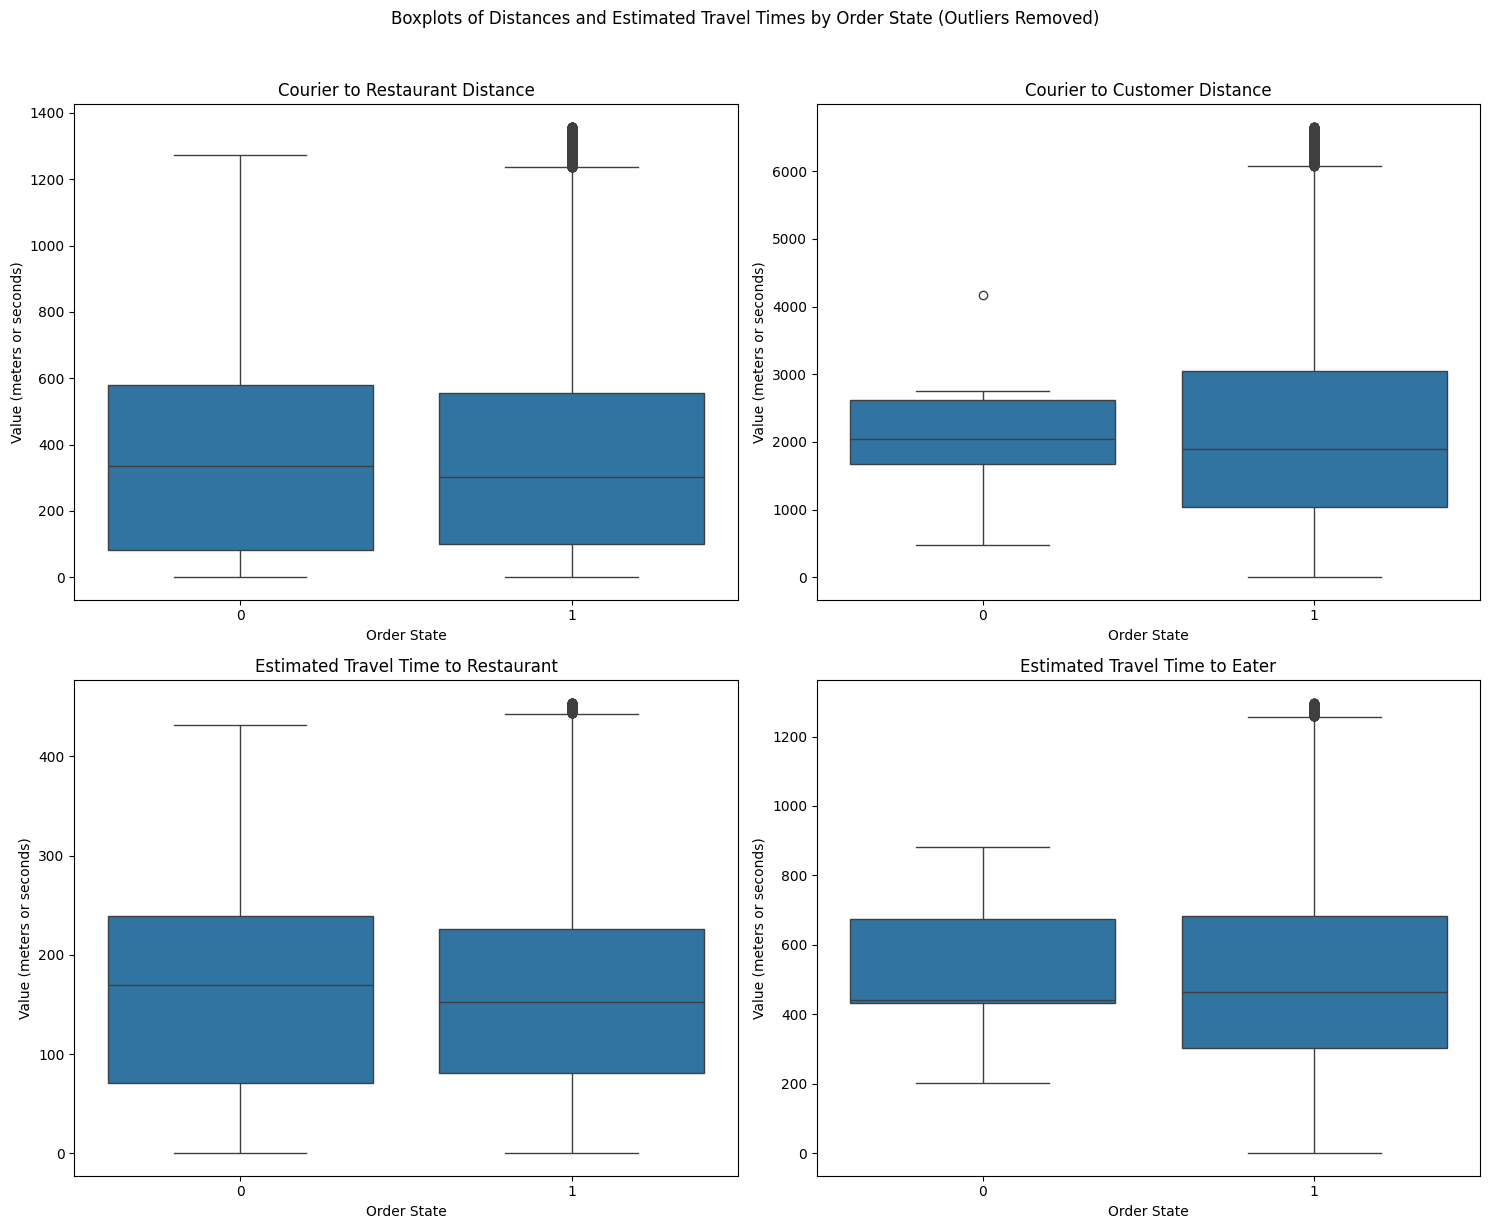

In [69]:

# First, let's remove the outliers to have a better visualization.
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Apply outlier removal to the relevant columns
df_distance_rest_filtered = remove_outliers(df_distance_rest, 'distance_courier_to_restaurant_address')
df_distance_customer_filtered = remove_outliers(df_distance_customer, 'distance_courier_to_customer_address')
df_distance_rest_filtered = remove_outliers(df_distance_rest_filtered, 'estimated_travel_time_in_seconds_to_restaurant')
df_distance_customer_filtered = remove_outliers(df_distance_customer_filtered, 'estimated_travel_time_in_seconds_to_eater')

# Define variables for distances and travel times
combined_variables = {
    'Courier to Restaurant Distance': ['df_distance_rest_filtered', 'distance_courier_to_restaurant_address'],
    'Courier to Customer Distance': ['df_distance_customer_filtered', 'distance_courier_to_customer_address'],
    'Estimated Travel Time to Restaurant': ['df_distance_rest_filtered', 'estimated_travel_time_in_seconds_to_restaurant'],
    'Estimated Travel Time to Eater': ['df_distance_customer_filtered', 'estimated_travel_time_in_seconds_to_eater']
}

# Create a grid of 2x2 plots for boxplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=False)

# Loop through the variables and create a boxplot for each
for ax, (title, (df_name, col)) in zip(axes.flatten(), combined_variables.items()):
    df = eval(df_name)  # Dynamically access the correct dataframe
    sns.boxplot(
        data=df,
        x='order_state',
        y=col,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Order State')
    ax.set_ylabel('Value (meters or seconds)')

plt.suptitle('Boxplots of Distances and Estimated Travel Times by Order State (Outliers Removed)', y=1.02)
plt.tight_layout()
plt.show()


It seems that the courier distance to restaurant is slightly higher for non-delivered orders. Let's evaluate the statistical significance of that difference.

In [71]:
df_distance_customer
# df_distance_rest


,order_id,order_state,order_stage,estimated_travel_time_in_seconds_to_eater,distance_courier_to_customer_address
3,1,1,courier_picked_up_order,756.0,4988.527960
9,2,1,courier_picked_up_order,522.0,3795.506954
15,3,1,courier_picked_up_order,365.0,2690.874188
21,4,1,courier_picked_up_order,327.0,1928.728030
27,5,1,courier_picked_up_order,643.0,4069.547292
...,...,...,...,...,...
386289,65580,1,courier_picked_up_order,191.0,776.256144
386295,65581,1,courier_picked_up_order,135.0,457.789867
386301,65582,1,courier_picked_up_order,740.0,5380.823289
386307,65583,1,courier_picked_up_order,341.0,890.605495


In [77]:
rest_columns = [
    'estimated_travel_time_in_seconds_to_restaurant',
    'distance_courier_to_restaurant_address'
]

customer_columns = [
    'estimated_travel_time_in_seconds_to_eater',
    'distance_courier_to_customer_address'
]

results_customer = [evaluate_statistical_significance(df_distance_customer, col) for col in customer_columns]
results_customer_df = pd.DataFrame(results_customer)

results_rest = [evaluate_statistical_significance(df_distance_rest, col) for col in rest_columns]
results_rest_df = pd.DataFrame(results_rest)



In [75]:
results_customer_df

,Column,Delivered_Normality_p,Not_Delivered_Normality_p,Test_Type,p_value
0,estimated_travel_time_in_seconds_to_eater,0.0,0.134958,Mann-Whitney U Test,0.234394
1,distance_courier_to_customer_address,0.0,0.003190,Mann-Whitney U Test,0.321311


In [76]:
results_rest_df

,Column,Delivered_Normality_p,Not_Delivered_Normality_p,Test_Type,p_value
0,estimated_travel_time_in_seconds_to_restaurant,0.0,5.466244e-02,Mann-Whitney U Test,0.418902
1,distance_courier_to_restaurant_address,0.0,1.915617e-08,Mann-Whitney U Test,0.441763


The results shows that there is no statistical significance in the distance of the courier to the restaurant or the customer in the analysis. <br>
**Distance is not a significant factor for order failure.**


#### Courier efficiency

Here I'll evaluate the efficiency of the courier based on the vehicle type.

In [78]:
df_order_staged_cleaned['vehicle_type'].unique()

array(['motorbike', 'car', 'bicycle'], dtype=object)

In [82]:
df_order_staged_cleaned.head()

,order_id,order_state,order_promised_delivery,restaurant_finished_preparation,restaurant_delivery_distance,dif_promised_preparation,log_id,city,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time
0,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,1.0,Bucharest,677.0,motorbike,order_proposed_to_courier,2021-10-15 03:04:02,26.082872,44.416126,NaN,NaN,649.953324,NaN,2021-10-15 03:27:30
1,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,2.0,Bucharest,677.0,motorbike,courier_accepts_order,2021-10-15 03:04:12,26.082872,44.416126,218.0,NaN,649.953324,NaN,2021-10-15 03:27:10
2,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,3.0,Bucharest,677.0,motorbike,courier_arrived_at_restaurant,2021-10-15 03:08:51,26.074600,44.414964,NaN,NaN,22.596096,NaN,2021-10-15 03:26:36
3,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,4.0,Bucharest,677.0,motorbike,courier_picked_up_order,2021-10-15 03:08:54,26.074581,44.414966,NaN,756.0,23.668382,4988.527960,2021-10-15 03:24:39
4,1,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,11.0,Bucharest,677.0,motorbike,courier_arrived_at_customer,2021-10-15 03:38:01,26.015199,44.428529,NaN,NaN,NaN,43.611625,2021-10-15 03:38:01


In [84]:
df_vehicle = df_order_staged_cleaned[['order_id','order_state','vehicle_type']].loc[df_order_staged_cleaned['order_stage']=='order_proposed_to_courier']
df_vehicle.head()

,order_id,order_state,vehicle_type
0,1,1,motorbike
6,2,1,motorbike
12,3,1,motorbike
18,4,1,motorbike
24,5,1,car


In [86]:
df_vehicle[['order_id','vehicle_type']].groupby('vehicle_type').count()

,order_id
vehicle_type,
bicycle,12963
car,5191
motorbike,46051


Now that we just saw the amount of orders by vehicle type, we should evaluate if it's possible that a specific vehicle type could influence the order failure.
Let's break down the problem into two parts:
1. Forumulate a hypothesis to evaluate if the vehicle type could influence the order failure.
2. Perform a chi-square test to evaluate the hypothesis. <br>

<br>

**Null hypothesis:** The vehicle type does not influence the order failure.
**Alternative hypothesis:** The vehicle type influences the order failure.

<br>

Let's perform the chi-square test.

In [89]:
# Step 1: Create a contingency table
contingency_table = pd.crosstab(df_vehicle['vehicle_type'], df_vehicle['order_state'])

# Step 2: Perform the chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-Squared Test Results:")
print(f"Chi2 Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Chi-Squared Test Results:
Chi2 Statistic: 2.8187516682329576
P-value: 0.2442957166284108
Degrees of Freedom: 2


*Based on the chi-squared test:*

We do not have sufficient evidence to conclude that the type of vehicle impacts the likelihood of order failure. <br>
<br>
**This implies that vehicle_type may not play a significant role in determining order success or failure.**

No further analysis is needed for this topic. Vehicle type alone does not influence the order failure.

### **So far we concluted that:** <br>
- **(Distance Analysis)**: Distance is not a significant factor for order failure. <br>
- **(Time related analysis)**: There is statistical significance to asume that time is a significant factor for order failure. <br>
- **(Courier efficiency)**: Vehicle type alone does not influence the order failure. <br>

But, can the agregation of the variables be a significant factor for order failure? <br>
Let's mess time with vehicle type and evaluate the statistical significance.

In [92]:
#We already have vehicle type in the df_time, so we can just work with that.

df_time.head()


,order_id,order_state,order_stage,courier_id,vehicle_type,order_promised_delivery,order_stage_start,restaurant_finished_preparation,updated_expected_delivery_time,dif_promised_expected,dif_finished_expected,dif_finished_promised,dif_start_expected,dif_start_promised,dif_start_finished
0,1,1,order_proposed_to_courier,677.0,motorbike,2021-10-15 03:31:11,2021-10-15 03:04:02,2021-10-15 03:08:44,2021-10-15 03:27:30,-221.0,1126.0,-1347.0,-1408.0,-1629.0,-282.0
6,2,1,order_proposed_to_courier,1970.0,motorbike,2021-10-15 03:46:07,2021-10-15 03:24:02,2021-10-15 03:24:22,2021-10-15 03:46:36,29.0,1334.0,-1305.0,-1354.0,-1325.0,-20.0
12,3,1,order_proposed_to_courier,843.0,motorbike,2021-10-15 04:00:30,2021-10-15 03:33:42,2021-10-15 03:45:39,2021-10-15 03:58:33,-117.0,774.0,-891.0,-1491.0,-1608.0,-717.0
18,4,1,order_proposed_to_courier,2410.0,motorbike,2021-10-15 04:15:53,2021-10-15 03:55:32,2021-10-15 04:08:40,2021-10-15 04:13:18,-155.0,278.0,-433.0,-1066.0,-1221.0,-788.0
24,5,1,order_proposed_to_courier,2588.0,car,2021-10-15 04:44:42,2021-10-15 04:14:42,2021-10-15 04:28:17,2021-10-15 04:41:12,-210.0,775.0,-985.0,-1590.0,-1800.0,-815.0


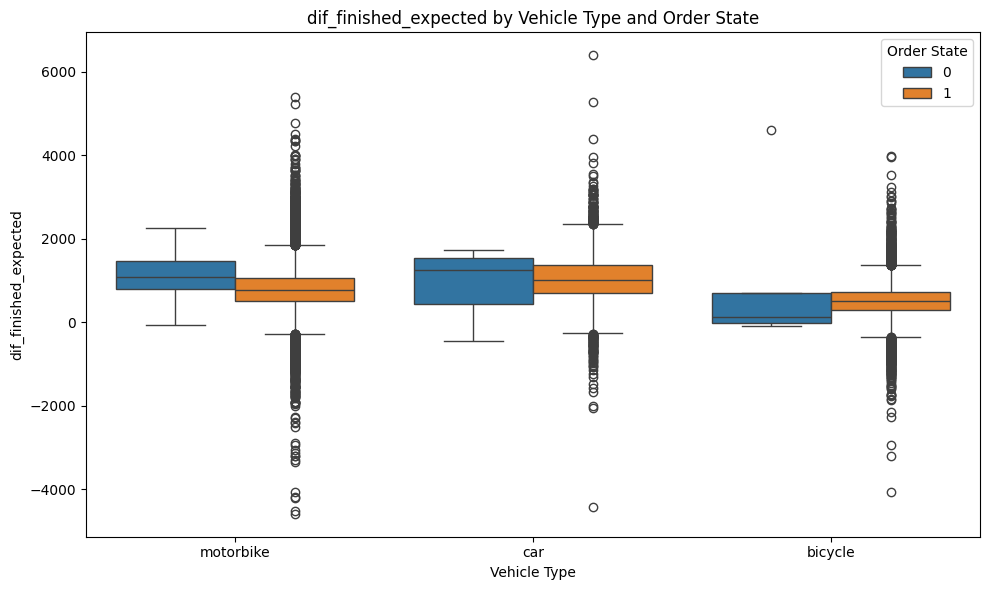

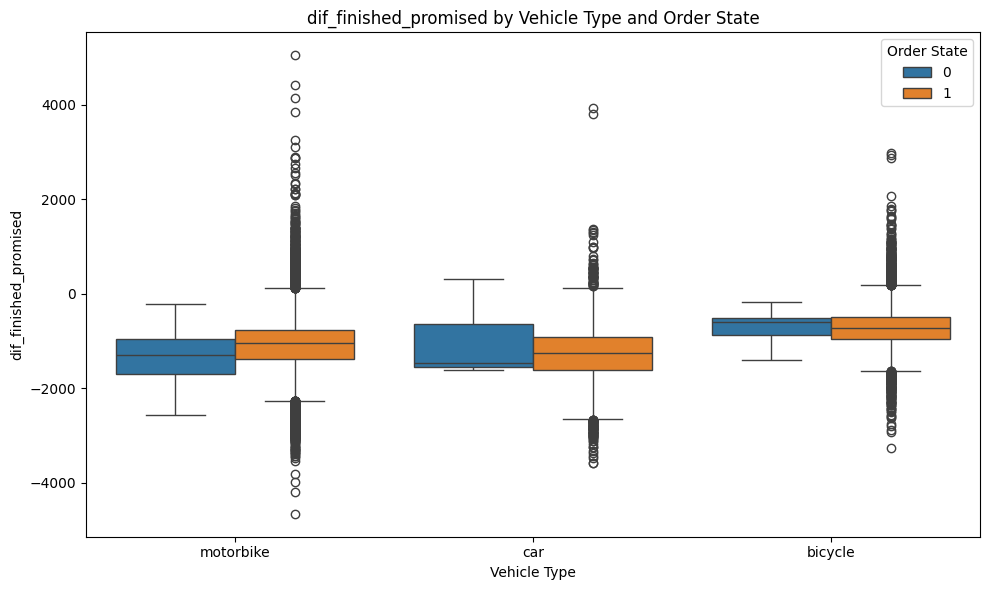

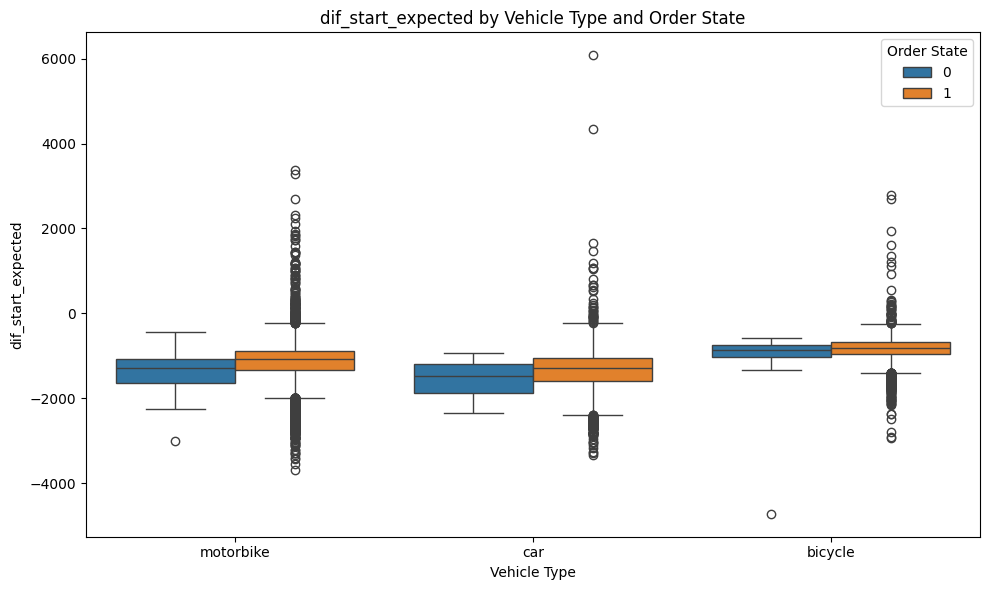

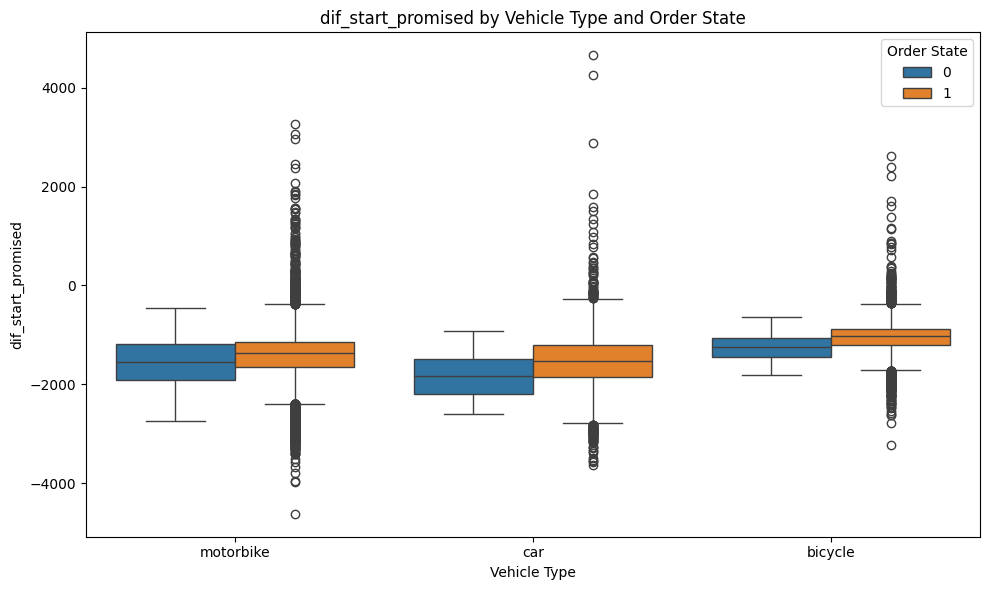

In [94]:
#Selecting the time related variables that we checked for statistical significance.
time_related_vars = ['dif_finished_expected', 'dif_finished_promised', 'dif_start_expected','dif_start_promised']

# Create boxplots for each variable
for var in time_related_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_time, x='vehicle_type', y=var, hue='order_state')
    plt.title(f'{var} by Vehicle Type and Order State')
    plt.xlabel('Vehicle Type')
    plt.ylabel(var)
    plt.legend(title='Order State', loc='upper right')
    plt.tight_layout()
    plt.show()

Using two-way ANOVA, we can evaluate the statistical significance of the interaction between vehicle type and time related variables.

Hypothesis
Null Hypothesis: The combination of vehicle type and time-related variables does not significantly impact cancellations. <br>
​
Alternative Hypothesis: Certain combinations of vehicle type and time-related variables increase the likelihood of cancellations.

In [95]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Two-way ANOVA for each time-related variable
for var in time_related_vars:
    formula = f'{var} ~ C(vehicle_type) + C(order_state) + C(vehicle_type):C(order_state)'
    model = ols(formula, data=df_time).fit()
    anova_results = anova_lm(model)
    print(f"ANOVA Results for {var}:")
    print(anova_results)

ANOVA Results for dif_finished_expected:
                                     df        sum_sq       mean_sq  \
C(vehicle_type)                     2.0  1.357259e+09  6.786294e+08   
C(order_state)                      1.0  4.299874e+06  4.299874e+06   
C(vehicle_type):C(order_state)      2.0  1.347058e+06  6.735291e+05   
Residual                        64148.0  1.589891e+10  2.478473e+05   

                                          F    PR(>F)  
C(vehicle_type)                 2738.094976  0.000000  
C(order_state)                    17.348887  0.000031  
C(vehicle_type):C(order_state)     2.717516  0.066046  
Residual                                NaN       NaN  
ANOVA Results for dif_finished_promised:
                                     df        sum_sq       mean_sq  \
C(vehicle_type)                     2.0  1.682749e+09  8.413747e+08   
C(order_state)                      1.0  1.433402e+06  1.433402e+06   
C(vehicle_type):C(order_state)      2.0  1.443356e+06  7.216782e+05  

****Key Takeaways from Two-Way ANOVA Analysis**** <br>

***1. Difference between Finished Preparation and Expected Delivery (dif_finished_expected) -*** ***This is the delivery time after launch.***
- Main Effects:
Vehicle Type: Significant (F=2738.09, p<0.001)
Vehicle type significantly influences the time difference
Order State: Significant (F=17.35, p=0.000031)
Order state (delivered vs failed) impacts the time difference

- Interaction Effect:
Marginally significant (F=2.72, p=0.066)
Weak evidence that the relationship between vehicle type and time difference depends on order state

***2. Difference between Finished Preparation and Promised Delivery (dif_finished_promised) -*** ***This is the promised delivery time after launch.***
- Main Effects:
Vehicle Type: Significant (F=3186.57, p<0.001)
Vehicle type significantly affects the time difference
Order State: Significant (F=5.43, p=0.019)
Order state impacts the time difference, but effect is smaller compared to other variables

- Interaction Effect:
Marginally significant (F=2.73, p=0.065)
Weak interaction between vehicle type and order state

***3. Difference between Order Start and Expected Delivery (dif_start_expected) -*** ***This is the expected delivery time in the beginning of the journey.****
- Main Effects:
Vehicle Type: Highly significant (F=4653.05, p<0.001)
Vehicle type strongly influences the time difference
Order State: Significant (F=39.67, p<0.001)
Order state has a strong impact on the time difference

- Interaction Effect:
Not significant (F=0.88, p=0.416)
No evidence of relationship between vehicle type and time difference depending on order state

***4. Difference between Order Start and Promised Delivery (dif_start_promised) -*** ***This is the promised delivery time in the beginning of the journey.***
- Main Effects:
Vehicle Type: Highly significant (F=4477.24, p<0.001)
Vehicle type strongly affects the time difference
Order State: Significant (F=13.77, p=0.0002)
Order state significantly impacts the time difference

- Interaction Effect:
Not significant (F=0.38, p=0.687)
No evidence of interaction effect

If vehicle type is influencing the time difference, it means that indirectly it can influence the order failure. <br>
***Time variables and vehicle type will be used to create a model to predict the order failure.***

## **Machine Learning Model**

Since we already selected the features that are statistically significant for the order failure, we can now proceed to the model creation.